In [20]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

# Category to Product mapping and weights
category_product_map = {
    "topup": ["ntc_topup", "ncell_topup", "smartcell_topup"],
    "bank_transaction": ["bank_withdrawal", "bank_deposit"],
    "bill_payment": ["electricity_bill", "water_bill", "internet_bill"],
    "entertainment": ["movie_ticket", "airline_ticket"],
    "loan": ["loan_repayment", "credit_card_payment"],
    "government": ["tax_payment", "govt_fee"],
    "insurance": ["insurance_payment"],
    "education": ["school_fee"],
    "shopping": ["online_shopping", "mobile_data_pack"]
}

category_weights = {
    "topup": 10,
    "bank_transaction": 6,
    "bill_payment": 8,
    "entertainment": 3,
    "loan": 5,
    "government": 3,
    "insurance": 4,
    "education": 5,
    "shopping": 7
}

# Festivals with format month-day and transaction multiplier
festivals = {
    "New Year Nepali": ("04-13", 3),
    "New Year English": ("01-01", 2.5),
    "Mother's Day": ("05-09", 1.5),
    "Buddha Jayanti": ("05-13", 1.8),
    "Teej": ("08-26", 2),
    "Indra Jatra": ("09-05", 1.5),
    "Dashain Day 1": ("10-05", 3),
    "Dashain Day 2": ("10-06", 3),
    "Dashain Day 3": ("10-07", 3),
    "Dashain Day 4": ("10-08", 3),
    "Dashain Day 5": ("10-09", 3),
    "Tihar Day 1": ("11-01", 3),
    "Tihar Day 2": ("11-02", 3),
    "Tihar Day 3": ("11-03", 3),
    "Tihar Day 4": ("11-04", 3),
    "Chhath": ("11-09", 2),
    "Christmas": ("12-25", 1.5),
    "Maghe Sankranti": ("01-14", 1.7),
    "Shivaratri": ("02-26", 2.5),
    "Holi": ("03-06", 2.8),
    "Valentine's Day": ("02-14", 2),
    "Rakhshya Bandhan": ("08-09", 1.5)
}

# Low activity events
low_activity_events = {
    "Earthquake": ["2023-06-15", "2023-06-16"],
    "Recession Alert": ["2024-02-10", "2024-02-11", "2024-02-12"]
}

# Date range
start_date = datetime(2022, 1, 1)
end_date = datetime(2025, 1, 1)
date_range = pd.date_range(start=start_date, end=end_date, freq="D")

# Helpers
def get_festival_info(date):
    month_day = date.strftime("%m-%d")
    for fest_name, (fest_day, multiplier) in festivals.items():
        if month_day == fest_day:
            return True, fest_name, multiplier
    return False, "", 1.0

def get_low_event_info(date):
    date_str = date.strftime("%Y-%m-%d")
    for event_name, dates in low_activity_events.items():
        if date_str in dates:
            return True, event_name, 0.3  # 70% drop in both amount and volume
    return False, "", 1.0

def get_trend_factors(date):
    days_passed = (date - start_date).days
    amount_trend = 0.02 * (days_passed / 365)
    volume_trend = 0.03 * (days_passed / 365)
    return amount_trend, volume_trend

# Data generation
data = []
for date in date_range:
    is_fest, fest_name, fest_multiplier = get_festival_info(date)
    is_low, low_event_name, low_multiplier = get_low_event_info(date)
    is_holiday = is_fest or date.weekday() == 6
    amount_trend, volume_trend = get_trend_factors(date)

    # Apply priority: low-activity overrides festival
    if is_low:
        event_name = low_event_name
        volume_multiplier = low_multiplier
        amount_multiplier = low_multiplier
    else:
        event_name = fest_name if is_fest else ""
        volume_multiplier = fest_multiplier
        amount_multiplier = fest_multiplier

    base_txns = random.randint(50, 100)
    scaled_txns = int(base_txns * (1 + volume_trend) * volume_multiplier)

    for _ in range(scaled_txns):
        category = random.choices(list(category_product_map.keys()), weights=list(category_weights.values()))[0]
        product = random.choice(category_product_map[category])
        base_amount = random.randint(50, 5000)
        final_amount = base_amount * (1 + amount_trend) * random.uniform(1.0, amount_multiplier)

        data.append([
            date.strftime("%Y-%m-%d"),
            category,
            product,
            round(final_amount, 2),
            is_fest,
            event_name,
            is_holiday
        ])

# Final DataFrame
df = pd.DataFrame(data, columns=[
    "transaction_date", "category", "product", "amount", "is_festival", "event_name", "is_holiday"
])
df.head(), len(df)


(  transaction_date          category            product   amount  is_festival  \
 0       2022-01-01             topup    smartcell_topup  7490.03         True   
 1       2022-01-01         insurance  insurance_payment  8769.24         True   
 2       2022-01-01  bank_transaction       bank_deposit  4631.36         True   
 3       2022-01-01         education         school_fee  6309.34         True   
 4       2022-01-01         insurance  insurance_payment  4842.33         True   
 
          event_name  is_holiday  
 0  New Year English        True  
 1  New Year English        True  
 2  New Year English        True  
 3  New Year English        True  
 4  New Year English        True  ,
 92015)

In [24]:
df.to_csv('./synthetic_data_v2.csv', index=False)

In [25]:
df.event_name.value_counts()

event_name
                    79498
New Year English      825
New Year Nepali       786
Dashain Day 5         760
Tihar Day 4           746
Tihar Day 3           692
Tihar Day 1           681
Tihar Day 2           660
Dashain Day 1         653
Dashain Day 4         628
Holi                  618
Dashain Day 3         598
Dashain Day 2         561
Shivaratri            513
Chhath                488
Maghe Sankranti       482
Teej                  461
Buddha Jayanti        456
Valentine's Day       449
Indra Jatra           419
Rakhshya Bandhan      350
Christmas             286
Mother's Day          282
Recession Alert        75
Earthquake             48
Name: count, dtype: int64

In [26]:
df.transaction_date = pd.to_datetime(df.transaction_date)
df.set_index('transaction_date', inplace=True)
df.sort_index(inplace=True)

In [27]:
df[df['event_name'] == 'Earthquake']

,category,product,amount,is_festival,event_name,is_holiday
transaction_date,,,,,,
2023-06-15,insurance,insurance_payment,3319.55,False,Earthquake,False
2023-06-15,shopping,online_shopping,561.76,False,Earthquake,False
2023-06-15,bill_payment,internet_bill,2673.84,False,Earthquake,False
2023-06-15,topup,ncell_topup,3307.97,False,Earthquake,False
2023-06-15,shopping,online_shopping,2259.13,False,Earthquake,False
2023-06-15,government,tax_payment,1995.58,False,Earthquake,False
2023-06-15,insurance,insurance_payment,4530.16,False,Earthquake,False
2023-06-15,education,school_fee,2329.26,False,Earthquake,False
2023-06-15,entertainment,airline_ticket,2127.02,False,Earthquake,False


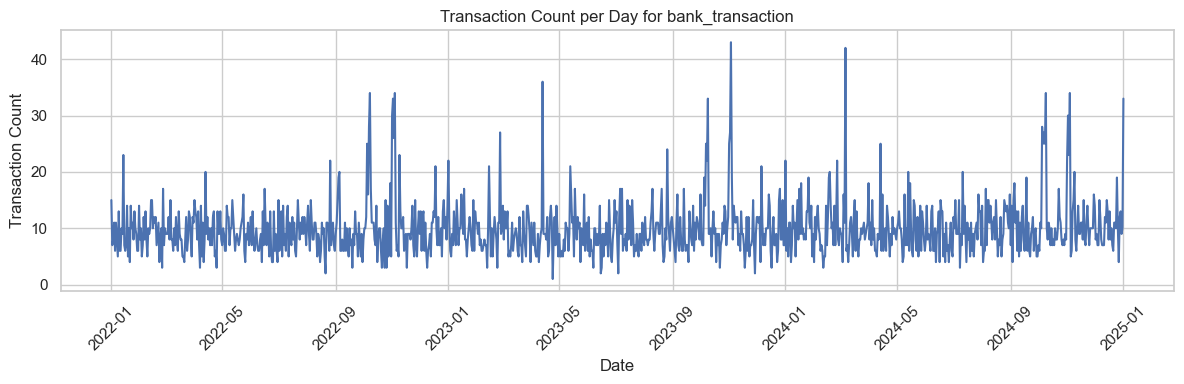

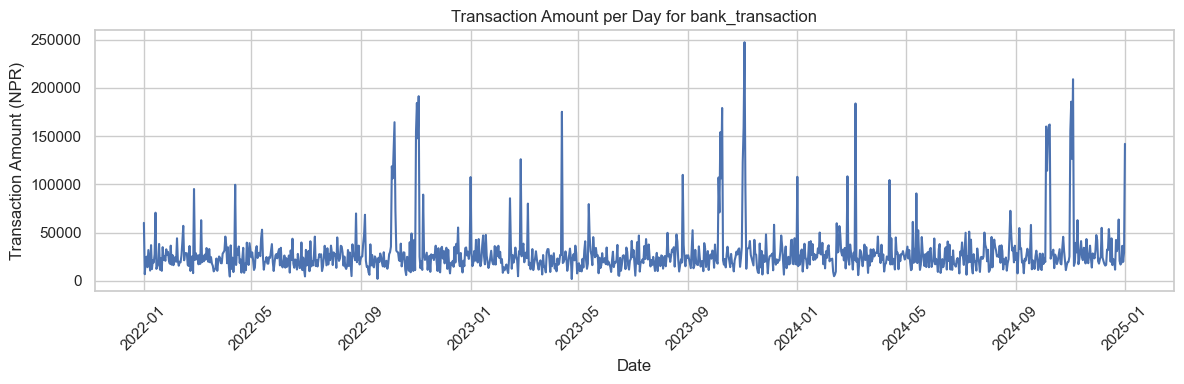

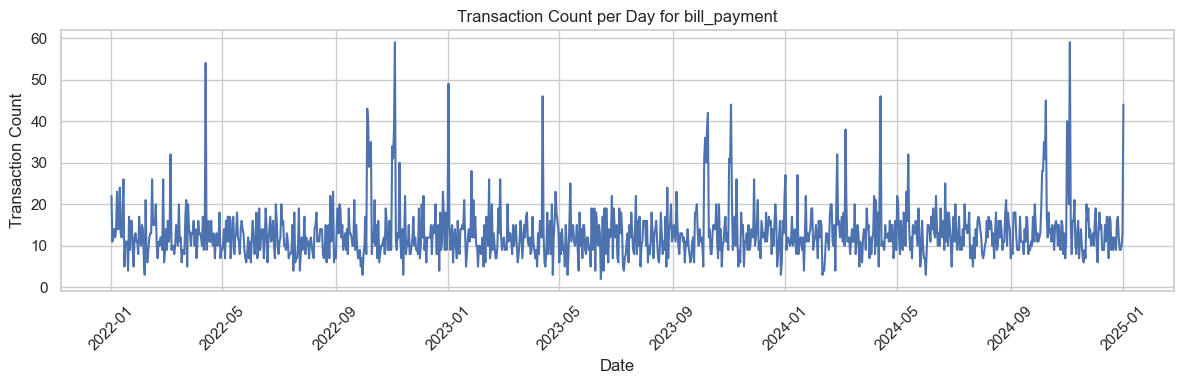

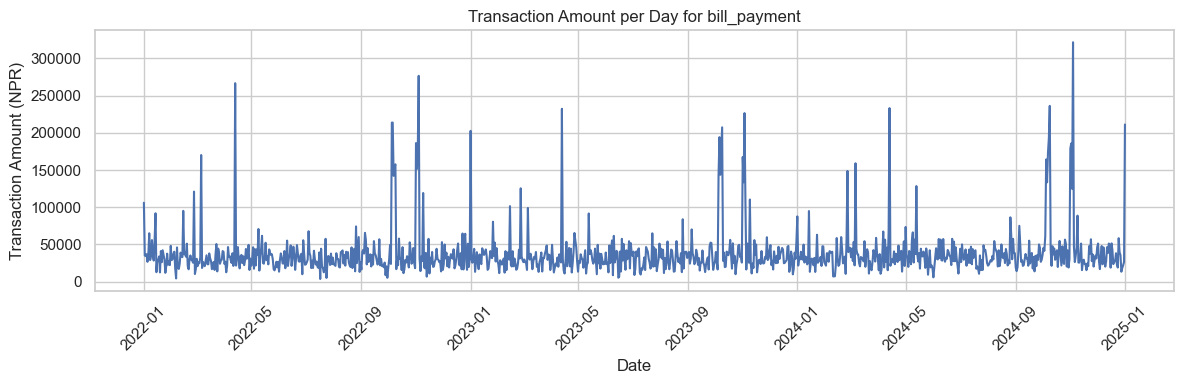

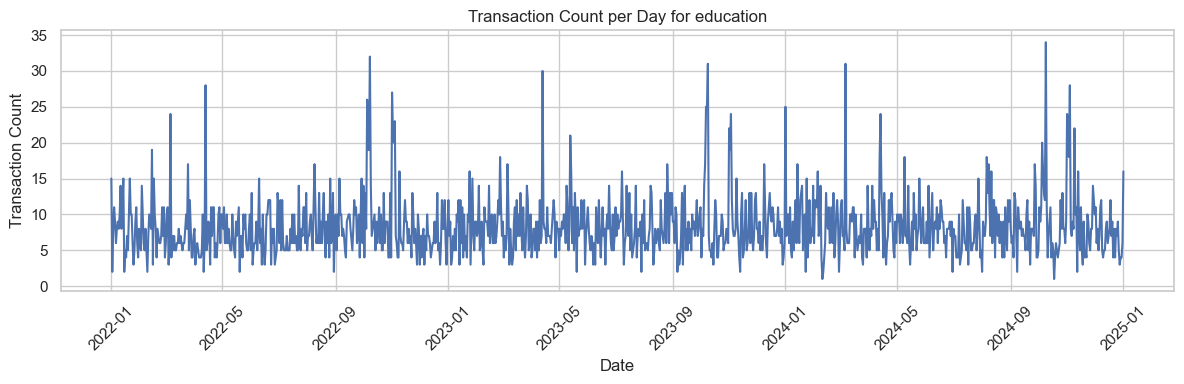

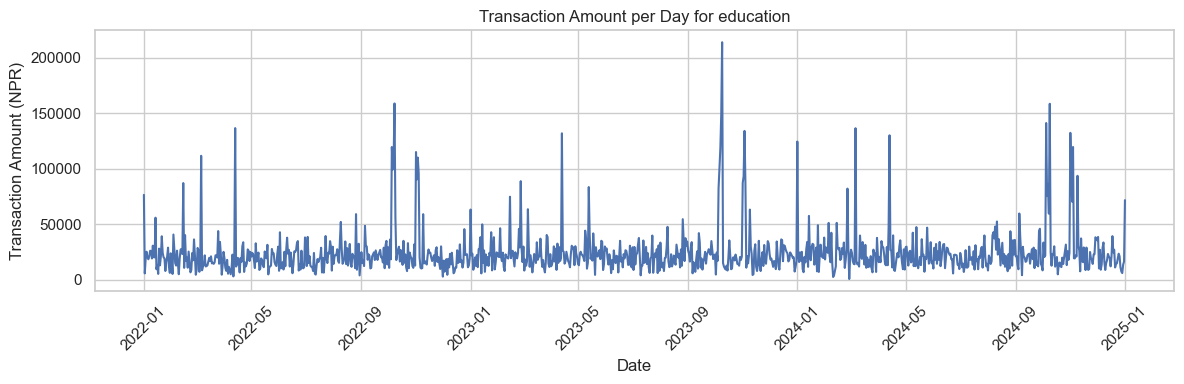

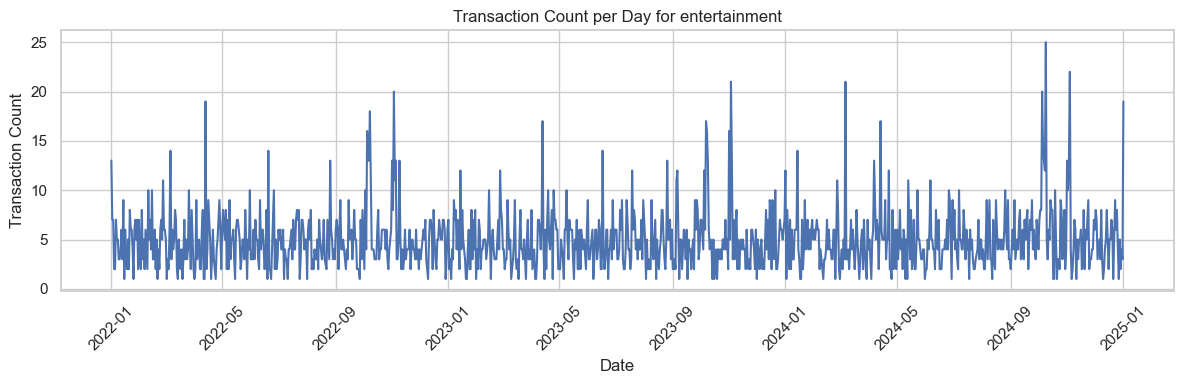

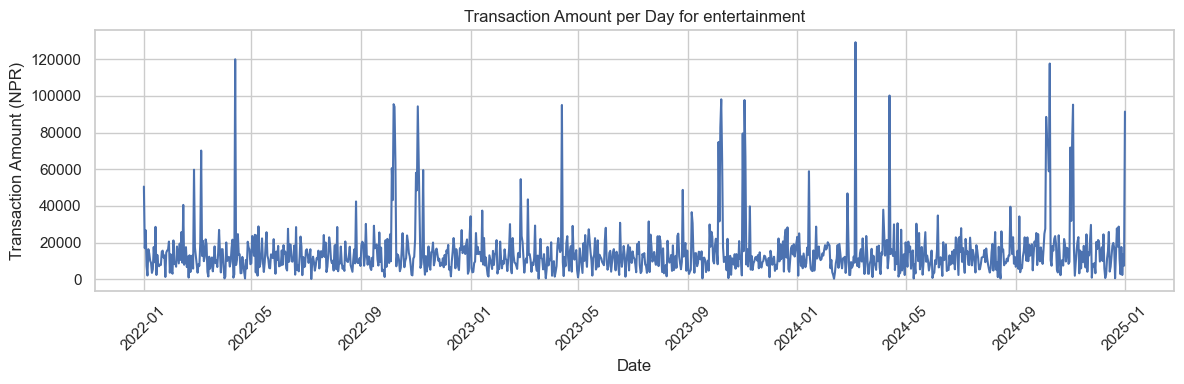

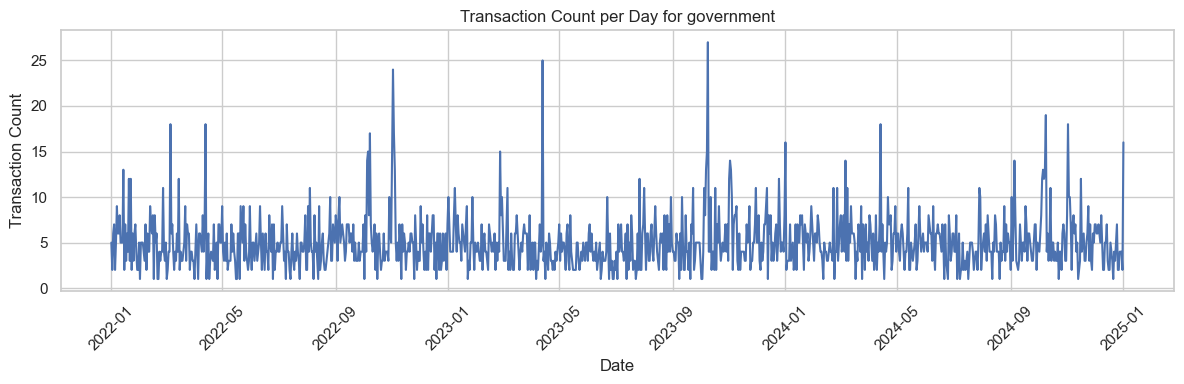

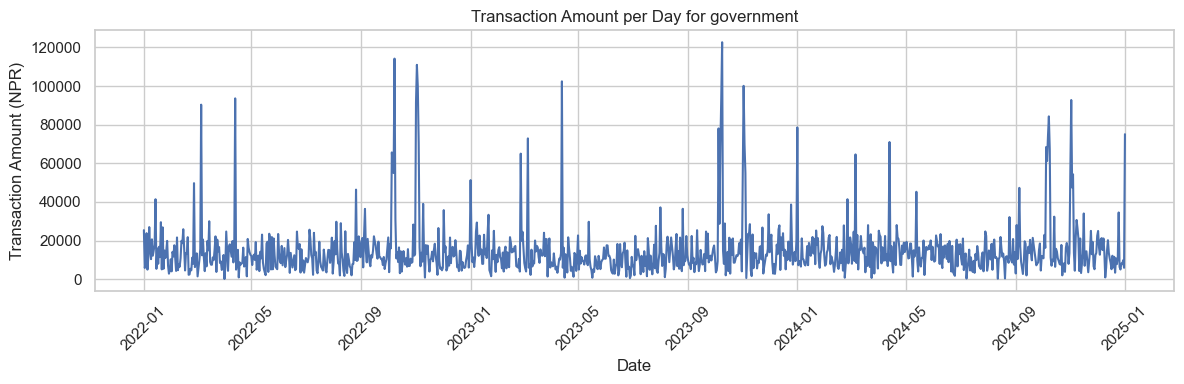

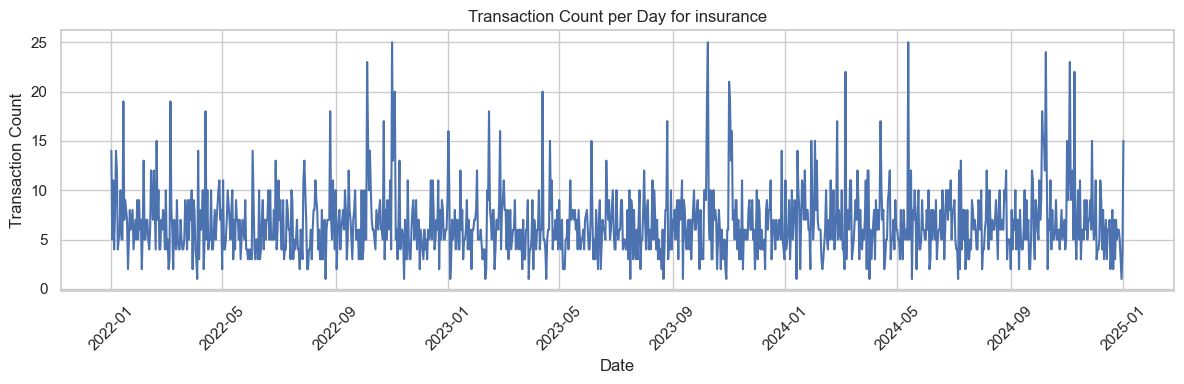

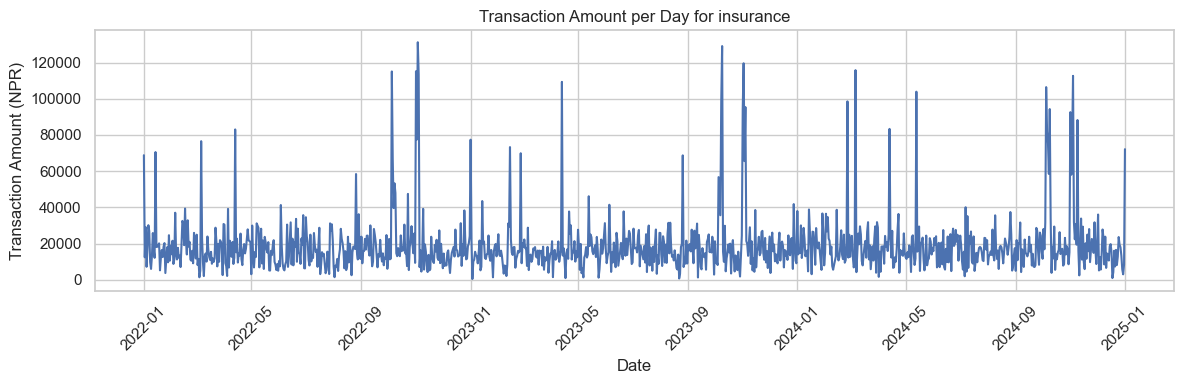

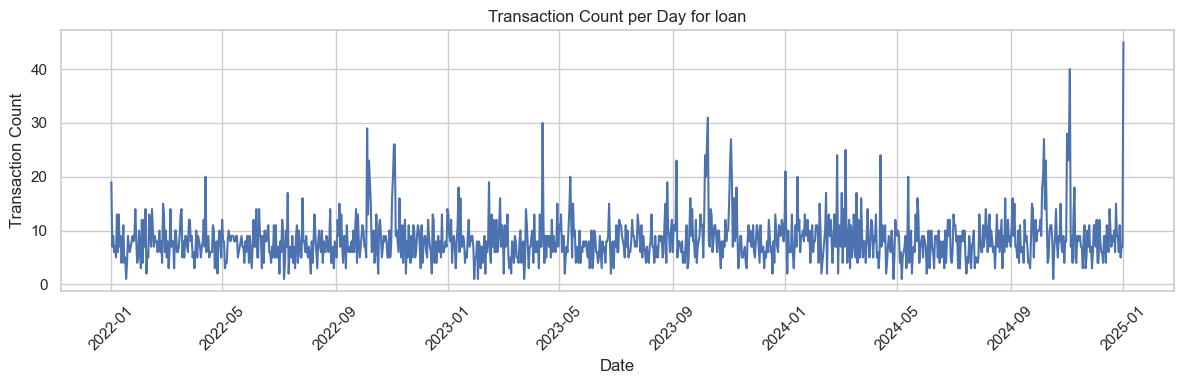

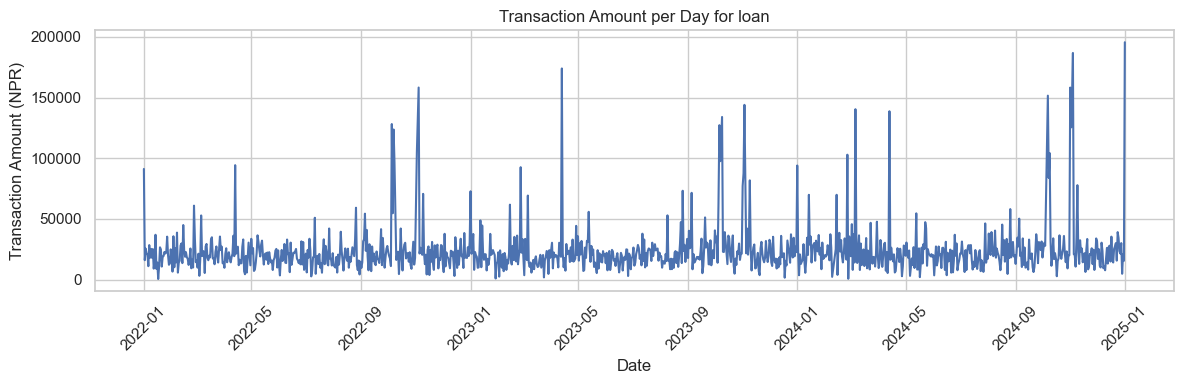

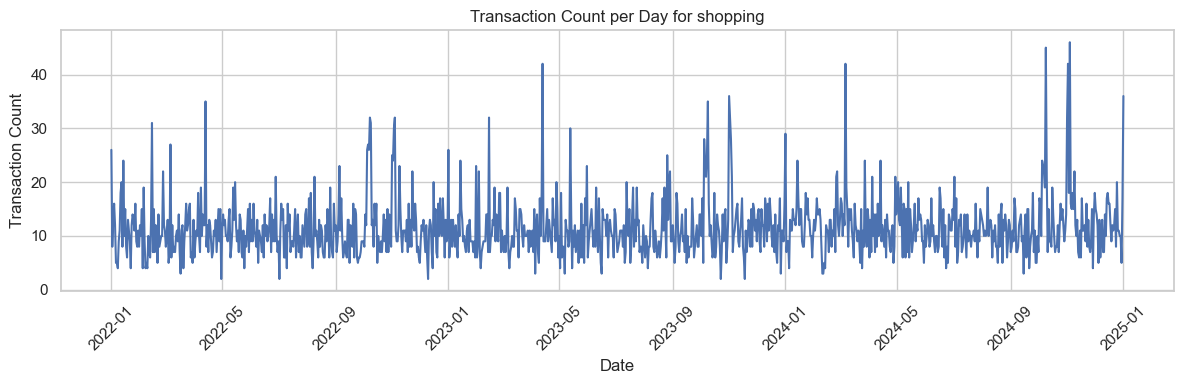

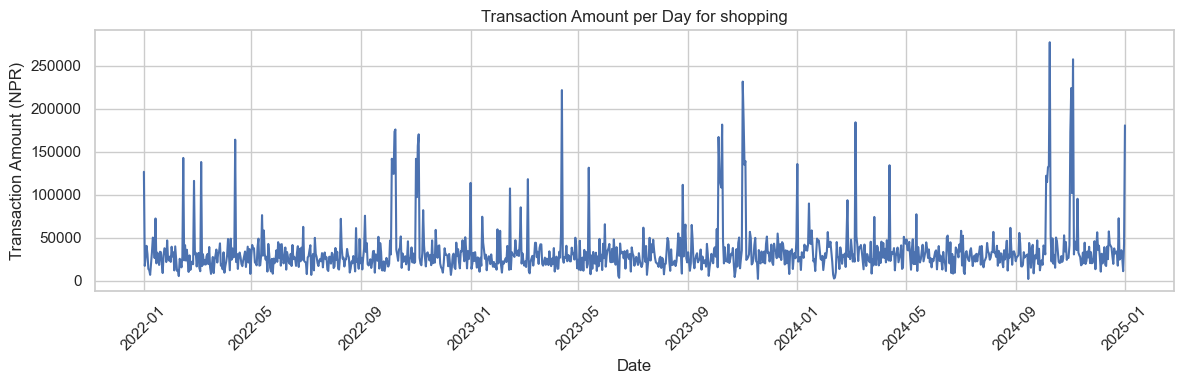

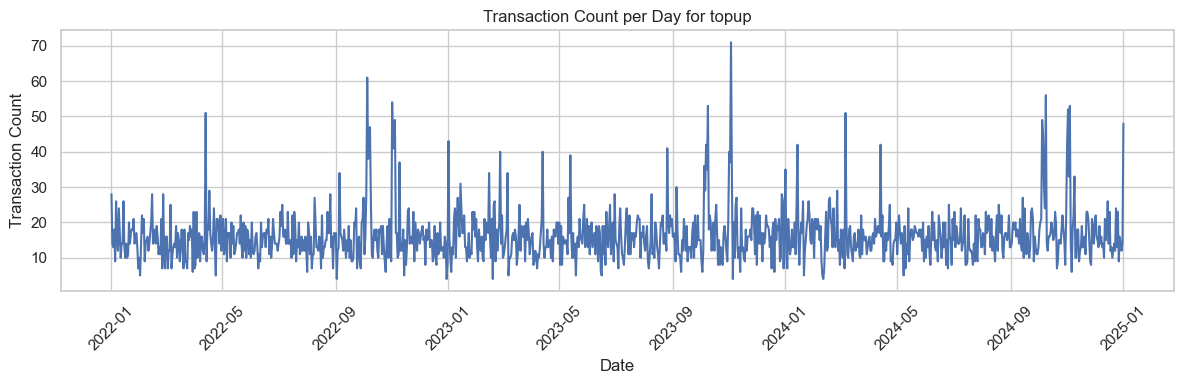

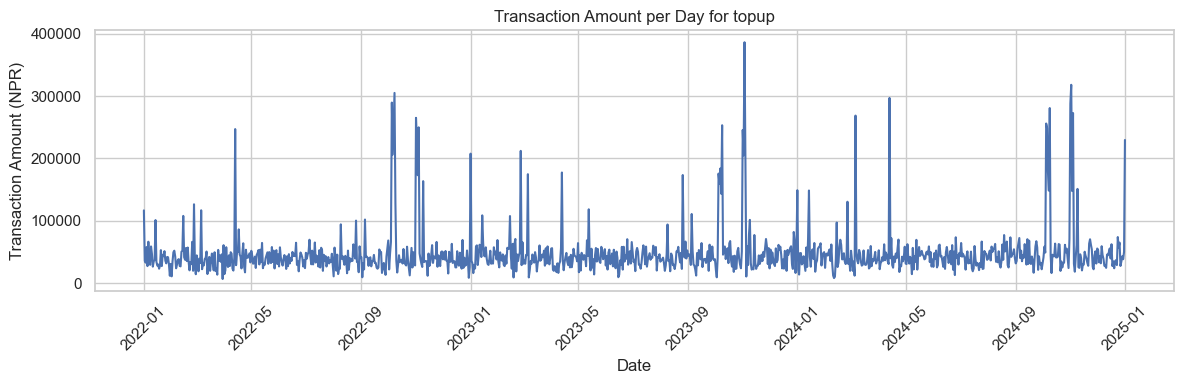

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Parse date and sort

df["category"] = df["category"].astype(str)

# Group by transaction_date and category
grouped = df.groupby(["transaction_date", "category"]).agg(
    transaction_count=("amount", "count"),
    transaction_amount=("amount", "sum")
).reset_index()

# Unique categories
categories = grouped["category"].unique()

# Set style
sns.set(style="whitegrid")

# Plot for each category
for cat in categories:
    cat_data = grouped[grouped["category"] == cat]

    # Count Plot
    plt.figure(figsize=(12, 4))
    sns.lineplot(data=cat_data, x="transaction_date", y="transaction_count")
    plt.title(f"Transaction Count per Day for {cat}")
    plt.xlabel("Date")
    plt.ylabel("Transaction Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Amount Plot
    plt.figure(figsize=(12, 4))
    sns.lineplot(data=cat_data, x="transaction_date", y="transaction_amount")
    plt.title(f"Transaction Amount per Day for {cat}")
    plt.xlabel("Date")
    plt.ylabel("Transaction Amount (NPR)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
